#**Neural Networks Project**<br>
**Implementing the paper [Pay Attention to MLPs](https://arxiv.org/pdf/2105.08050v1.pdf)**<br>

by *Daniel Caliman* (2122749, calimandaniel5@gmail.com) and *Nikolas Jochens* (2118698, nj@andaco.de)

## **Imports**

In [1]:
# Imports
%pip install torchmetrics --quiet

from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from IPython.display import Image as ImageInternet
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

Note: you may need to restart the kernel to use updated packages.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Introduction**
We read the paper [Pay Attention to MLPs](https://arxiv.org/pdf/2105.08050v1.pdf) and implemented the neural network architecture described in it to classify image datasets. After we got our implementation to work we started experimenting with different datasets and tried to tune the parameters in different ways to improve the results we got. We used the following three datasets:

- **[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html):** The dataset contains 60,000 color images with a size 32x32 pixels that are labeled into 10 different classes, such as dog, bird and airplane.

- **(Tiny) [ImageNet](https://www.image-net.org/):** The original dataset contains over a million color images with a size 256x256 pixels that are labeled into 1000 different classes. Due to our limited computing power we used a subset of the dataset containing only 100000 samples with 200 classes. Hence the tiny.

- **[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist):** The dataset contains 60,000 grayscale images of clothes with a size 28x28 pixels that are labeled into 10 different classes, such as dress, sneaker and bag.

- **[EuroSAT_RGB](https://github.com/phelber/eurosat):** The dataset contains 27,000 color images of european landmasses from a satellite with a size 64x64 pixels that are labeled into 10 different classes, such as forest, highway and river.

We documented the results we got in the section **Results on Datasets** at the end of this notebook.<br>
We will begin by briefly describing the implemented architecture and it's advantages.

## **Summary of gMLP Architecture**

The paper proposes an architecture without self-attention modules for vision applications and Natural Language Processing (NLP) as a way point to possible alternatives for Transformers. The proposed model is called gMLP, as it mainly uses basic Multi-Layer Perceptron (MLP) layers together with a gating mechanism.

We will now give an overview on how the model actually works. The general layout of the architecture is presented in the following picture.

In [3]:
# Load architecture image
ImageInternet(url= "https://miro.medium.com/v2/resize:fit:1038/0*meP8Mh-0bCL_KTLO.png", width=500)

1. The first step of the architecture is the **Input Embedding** to turn the input into a suitable tensor that can be fed into the rest of the network. The output tensor of this embedding must have a channel dimension of ``d_model``.
2. Next the tensor is fed into **``Lx`` gMLP blocks** that are connected in series and share the same design, each have their own trainable parameters. These blocks do the following:
3. A **copy of** the gMLP blocks **input** is created and separately stored.
4. The input is fed through a **Normalization** layer that performs **Layer Normalization**.
5. The normalized input is fed through a **Channel Projection** layer over the channel axis that consists of a single **Fully Connected Linear Layer** with ``d_ffn`` output nodes. ``d_ffn`` is usually larger than ``d_model``.
6. The projection output is then fed into a **Gaussian Error Linear Unit Activation Layer**.
7. The Activation Layer output is fed into the so called **Spatial Gating Unit**.
    1. In the Spatial Gating Unit the input is first **split into two equally sized parts along the channel axis** ``u`` and ``v``., meaning they both have a channel size of ``d_ffn/2``
    2. ``v`` is then fed through a **Normalization** layer that performs **Layer Normalization**.
    3. The normalized ``v`` is then fed through another **Projection** layer that consists of a single **Fully Connected Linear Layer** with the same number of output nodes as input nodes. This layer is not applied over the channel dimension as before, but over the spatial dimension. Therefor the layer has ``seq_len`` input and output nodes. This layer is initialized with weights close to zero and biases equal to one, as for it to initially only act as an identity mapping and only later on capture certain spatial interdependencies between the networks input.
    4. Next the spatially transformed ``v`` is **element-wise multiplied** with ``u`` and output.
8. The output of the Spatial Gating Unit is then fed through another **Projection** layer over the channel axis with an output size of ``d_model``.
9. As a last step the shortcut is added to the output to enable the model to better train for identity mappings. The output of this operation is passed to the next block that repeats this whole process.

The authors of the paper trained their architecture to classify the ImageNet dataset and to work with BERT Masked Language Modelling. As we only applied it to a vision task ourselves, we will focus on the papers results for ImageNet.<br><br>
The paper proposes three differently configured versions of their network, each containing the following parameters:
<br>


|Model| Lx | d_model | d_ffn | dropout probability |
|---|---|---|---|---|
| gMLP-Ti | 30 | 128 | 768 | 0.01    |
| gMLP-S  | 30 | 256 | 1536  | 0.05    |
| gMLP-B  | 30 | 512 | 3072  | 0.1     |


They achieved the following results on the ImageNet dataset:

| Model | Accuracy |
|---|---|
| gMLP-Ti | 72% |
| gMLP-S  | 79.4% |
| gMLP-B  | 81.6% |


Compared with other architectures these are good results.

## **Overview of our Implementation**

Our implementation is divided into the following sections:
- **Implementation of gMLP:** Module definitions for the main components of gMLP and our use case as an image classifier: ``SpatialGatingUNIT``, ``gMLPBlock``, ``gMLP`` and ``gMLPImage``.
- **Supporting Methods:** Used for the different evaluations performed: ``evaluate_model``. ``get_accuracy``
- **Training Methods:** Used to train our models: ``loop_vm``
- Sections for the training of the different datasets. These are each composed of the following subsections:
 - **Set parameters**
 - **Import of dataset and preparation of DataLoaders**
 - **Create the model with given parameters and move it to device**
 - **Train the models on the dataset**
 - **Evaluate the model and get the confusion matrix**

All important parts of our code are explained through comments in the code. The evaluation of the models happens both during training with a validation dataset, as well as after the network has been trained with a test dataset. We output accuracy, precision, recall and a confusion matrix. We will now begin with the actual code sections.

## **Implementation of gMLP**

In [4]:
# class defenition of the Spatial Gating Unit
class SpatialGatingUnit(nn.Module):

  def __init__(self, d_ffn, seq_len):
    super(SpatialGatingUnit, self).__init__()

    self.normalization = nn.LayerNorm(d_ffn // 2)
    self.spatial_projection = nn.Linear(seq_len, seq_len)
    # weights are initialized as close to zero and biases as one
    weights = torch.empty((seq_len, seq_len))
    nn.init.xavier_uniform_(weights)
    weights *= 0.001
    nn.init.ones_(self.spatial_projection.bias)


  def forward(self, x):
    u, v = x.chunk(2, dim=-1) # split x into two equal parts u and v along the channel axis
    v = self.normalization(v) # perform layer normalization to v
    v = v.permute(0, 2, 1) # change the channel with the spatial dimension for v
    v = self.spatial_projection(v) # perform spatial projection
    v = v.permute(0, 2, 1) # change the channel with the spatial dimension back to normal
    return u * v # return the product of the element-wise multiplicated tensors

In [5]:
# class definition of an gMLP block
class gMLPBlock(nn.Module):

  def __init__(self, d_model, d_ffn, seq_len, dropout_prob):
    super(gMLPBlock, self).__init__()

    self.normalization = nn.LayerNorm(d_model)
    self.projection = nn.Linear(d_model, d_ffn)
    self.activation = nn.GELU()
    self.spatial_gating_unit = SpatialGatingUnit(d_ffn, seq_len)
    self.projection2 = nn.Linear(d_ffn // 2, d_model)
    self.dist = torch.distributions.bernoulli.Bernoulli(torch.Tensor([dropout_prob]))

  def forward(self, x):
    if self.training and torch.equal(self.dist.sample(), torch.zeros(1)):
      return x # if network is training perform dropout with the given probability
    shortcut = x # save copy of x for the shortcut
    x = self.normalization(x) # perform normalization
    x = self.projection(x) # perform projection from d_model to d_ffn along channels
    x = self.activation(x) # perform gelu activation
    x = self.spatial_gating_unit(x) # perform spatial gating unit
    x = self.projection2(x) # peform projection from d_ffn/2 to d_model along channels
    return x + shortcut # add shortcut

In [6]:
# class definition of the gMLP model
class gMLP(nn.Module):

  def __init__(self, d_model, d_ffn, seq_len, lx, dropout_probs):
    super(gMLP, self).__init__()

    self.dropout_probs = torch.linspace(dropout_probs[0], dropout_probs[1], lx)
    self.blocks = nn.Sequential(*[gMLPBlock(d_model, d_ffn, seq_len, dropout_prob) for dropout_prob in self.dropout_probs])

  def forward(self, x):
    x = self.blocks(x) # perform lx sequential blocks of gmlp
    return x

In [7]:
# class definition of gMLP for image classification
class gMLPImage(nn.Module):

  def __init__(self, d_model, d_ffn, lx, patch_size, image_size, channels, classes, dropout_probs):
    super(gMLPImage, self).__init__()
    self.seq_len = (image_size // patch_size) ** 2
    self.patch_embedding = nn.Conv2d(channels, d_model, kernel_size=patch_size, stride=patch_size)
    self.gmlp = gMLP(d_model, d_ffn, self.seq_len, lx, dropout_probs)
    self.output = nn.Linear(d_model, classes)

  def forward(self, x):
    x = self.patch_embedding(x) # do the patch embedding via a 2d conv
    x = x.permute(0, 2, 3, 1)  # rearrange dimensions to (batch_size, height, width, channels)
    x = x.contiguous().view(x.size(0), -1, x.size(-1))  # flattening into a single dimension of shape (batch_size, height*width, channels)
    x = self.gmlp(x) # perform gmlp
    x = x.mean(1) # perform global average pooling
    x = self.output(x) # perform projection onto the desired number of output classes
    return x


## **Supporting Methods**

In [8]:
# Evaluate the model on the test dataset
def evaluate_model(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm.tqdm(loader, desc="Evaluation"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return accuracy, precision, recall, conf_matrix

In [9]:
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

## **Training Methods**

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
def loop_vm(net, loader, opt, is_train):
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm.tqdm(loader, total=len(loader))
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc.item())
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        if is_train:
          pbar.set_description(f'Training  : Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')
        else:
          pbar.set_description(f'Validation: Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')

## **CIFAR10**

### **Set parameters**

In [12]:
epochs = 6                 # number of epochs to complete
d_model = 220               # d_model
d_ffn = 900                 # d_ffn
lx = 6                     # number of blocks to be sequentially executed
patch_size = 2              # patch size for patch embedding convolution
image_size = 32             # size of the input images (must be square)
classes = 10                # number of output classes
channels = 3                # number of input channels (in our case rgb)
dropout_probs = [0.9, 0.9]    # first and last value of droput probabilities that are used to created a linspace with a dropout prob for each block
batch_size = 64             # batch size for the gradient descent
eval_ratio = 0.2              # ratio of dataset used for validation

### **Import of CIFAR-10 and preparation of DataLoaders**

In [13]:
T = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

CIFAR10_train = datasets.CIFAR10("data/", train=True, download=True, transform=T)
class_names = CIFAR10_train.classes
CIFAR10_test = datasets.CIFAR10("data/", train=False, download=True, transform=T)
CIFAR10_train, CIFAR10_val = random_split(CIFAR10_train, [int(len(CIFAR10_train) * (1 - eval_ratio)), int(len(CIFAR10_train) * eval_ratio)])

train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(CIFAR10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(CIFAR10_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


### **Create the model with given parameters and move it to device**

In [14]:
gmlp = gMLPImage(d_model = d_model,
                 d_ffn = d_ffn,
                 lx = lx,
                 patch_size = patch_size,
                 image_size = image_size,
                 channels = channels,
                 classes = classes,
                 dropout_probs = dropout_probs
                 ).to(device)

### **Train the models on the CIFAR10 dataset**

In [15]:
opt = torch.optim.Adam(gmlp.parameters()) # set optimizer to the adam optimizer

for epoch in range(epochs):
    loop_vm(gmlp, train_loader, opt, True)
    loop_vm(gmlp, val_loader, opt, False)

Validation: Epoch: 6 Loss: 0.9340 Acc: 0.6896: 100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


### **Evaluate the model and get the confusion matrix**

Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Test Accuracy: 68.74%
Test Precision: 68.74%
Test Recall: 68.74%


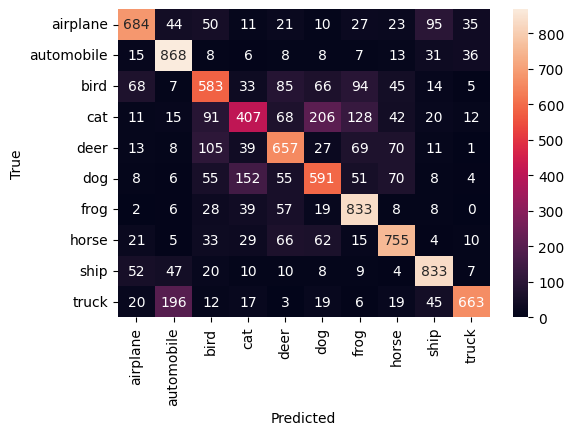

In [16]:
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **(Tiny) ImageNet**

### **Set parameters**

In [21]:
epochs = 1                  # number of epochs to complete
d_model = 1                 # d_model
d_ffn = 2                   # d_ffn
lx = 1                      # number of blocks to be sequentially executed
patch_size = 16              # patch size for patch embedding convolution
image_size = 64             # size of the input images (must be square)
classes = 200               # number of output classes
channels = 3                # number of input channels (in our case rgb)
dropout_probs = [0.9, 0.9]  # first and last value of dropout probabilities that are used to created a linspace with a dropout prob for each block
batch_size = 256             # batch size for the gradient descent
eval_ratio = 0.2            # ratio of dataset used for validation

### **Import of (Tiny) ImageNet and preparation of DataLoaders**

In [22]:
T = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

Tiny_ImageNet_train = datasets.ImageFolder('tiny-imagenet-200/train', transform=T)
Tiny_ImageNet_test = datasets.ImageFolder('tiny-imagenet-200/test', transform=T)
Tiny_ImageNet_val = datasets.ImageFolder('tiny-imagenet-200/val', transform=T)

class_names = Tiny_ImageNet_train.classes

train_loader = DataLoader(Tiny_ImageNet_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(Tiny_ImageNet_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(Tiny_ImageNet_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### **Create the model with given parameters and move it to device**

In [23]:
gmlp = gMLPImage(d_model = d_model,
                 d_ffn = d_ffn,
                 lx = lx,
                 patch_size = patch_size,
                 image_size = image_size,
                 channels = channels,
                 classes = classes,
                 dropout_probs = dropout_probs
                 ).to(device)

### **Train the models on the (Tiny) ImageNet dataset**

In [24]:
opt = torch.optim.Adam(gmlp.parameters()) # set optimizer to the adam optimizer

for epoch in range(epochs):
    loop_vm(gmlp, train_loader, opt, True)
    loop_vm(gmlp, val_loader, opt, False)

Validation: Epoch: 1 Loss: 5.1182 Acc: 0.0000: 100%|██████████| 40/40 [00:27<00:00,  1.47it/s]


### **Evaluate the model and get the confusion matrix**

Evaluation: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


Test Accuracy: 0.00%
Test Precision: 0.00%
Test Recall: 0.00%


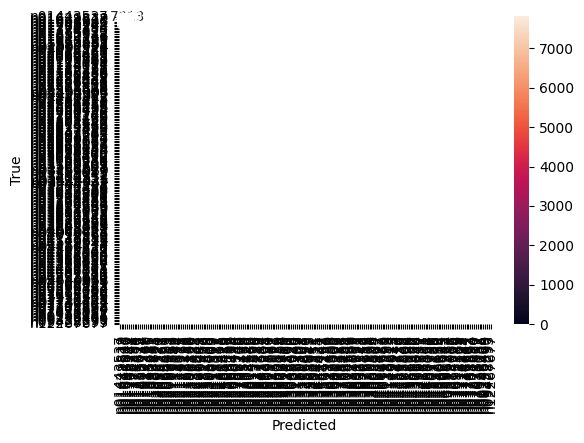

In [25]:
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Fashion-MNIST**

### **Set parameters**

In [12]:
epochs = 9                 # number of epochs to complete
d_model = 300               # d_model
d_ffn = 900                 # d_ffn
lx = 10                     # number of blocks to be sequentially executed
patch_size = 2              # patch size for patch embedding convolution
image_size = 28             # size of the input images (must be square)
classes = 10                # number of output classes
channels = 1                # number of input channels (in our case grayscale)
dropout_probs = [0.9, 0.9]    # first and last value of droput probabilities that are used to created a linspace with a dropout prob for each block
batch_size = 64             # batch size for the gradient descent
eval_ratio = 0.2              # ratio of dataset used for validation

### **Import of Fashion-MNIST and preparation of DataLoaders**

In [33]:
T = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

FashionMNIST_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=T)
class_names = FashionMNIST_train.classes
FashionMNIST_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=T)
FashionMNIST_train, FashionMNIST_val = random_split(FashionMNIST_train, [int(len(FashionMNIST_train) * (1 - eval_ratio)), int(len(FashionMNIST_train) * eval_ratio)])

train_loader = DataLoader(FashionMNIST_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(FashionMNIST_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(FashionMNIST_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### **Create the model with given parameters and move it to device**

In [38]:
gmlp = gMLPImage(d_model = d_model,
                 d_ffn = d_ffn,
                 lx = lx,
                 patch_size = patch_size,
                 image_size = image_size,
                 channels = channels,
                 classes = classes,
                 dropout_probs = dropout_probs
                 ).to(device)

### **Train the models on the Fashion-MNIST dataset**

In [39]:
opt = torch.optim.Adam(gmlp.parameters()) # set optimizer to the adam optimizer

for epoch in range(epochs):
    loop_vm(gmlp, train_loader, opt, True)
    loop_vm(gmlp, val_loader, opt, False)

Evaluation: Epoch: 10 Loss: 0.2786 Acc: 0.9034: 100%|██████████| 188/188 [00:05<00:00, 33.28it/s]


### **Evaluate the model and get the confusion matrix**

Final evaluation: 100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


Test Accuracy: 89.79%
Test Precision: 89.79%
Test Recall: 89.79%


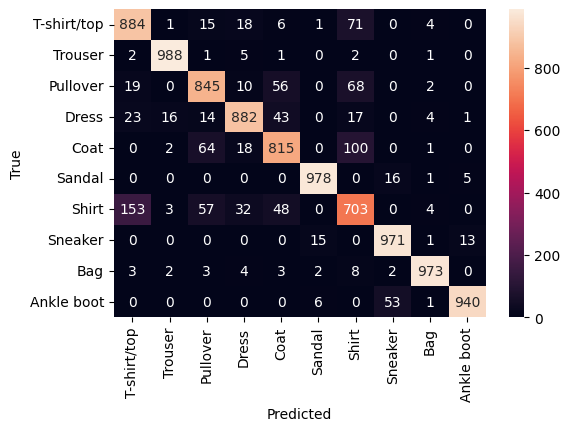

In [40]:
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **EuroSAT_RGB**

In [13]:
epochs = 15                 # number of epochs to complete
d_model = 280               # d_model
d_ffn = 560                 # d_ffn
lx = 6                     # number of blocks to be sequentially executed
patch_size = 4              # patch size for patch embedding convolution
image_size = 56             # size of the input images (must be square)
classes = 10                # number of output classes
channels = 3                # number of input channels (in our case grayscale)
dropout_probs = [1, 0.9]    # first and last value of droput probabilities that are used to created a linspace with a dropout prob for each block
batch_size = 64             # batch size for the gradient descent
eval_ratio = 0.2              # ratio of dataset used for validation

### **Import of EuroSAT_RGB and preparation of DataLoaders**

In [15]:
T = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

EuroSAT_RGB_full = datasets.DatasetFolder(root='./EuroSAT_RGB', loader=Image.open, transform=T, extensions = 'jpg')

# Get the target
targets = EuroSAT_RGB_full.targets

# Split the full dataset into a training dataset and a temporary dataset
EuroSAT_RGB_train, temp_data, train_targets, temp_targets = train_test_split(EuroSAT_RGB_full, targets, test_size=0.2, stratify=targets)

# Split the temporary dataset into validation and test datasets
EuroSAT_RGB_val, EuroSAT_RGB_test, val_targets, test_targets = train_test_split(temp_data, temp_targets, test_size=0.5, stratify=temp_targets)

class_names = EuroSAT_RGB_full.classes

train_loader = DataLoader(EuroSAT_RGB_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(EuroSAT_RGB_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(EuroSAT_RGB_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### **Create the model with given parameters and move it to device**

In [16]:
gmlp = gMLPImage(d_model = d_model,
                 d_ffn = d_ffn,
                 lx = lx,
                 patch_size = patch_size,
                 image_size = image_size,
                 channels = channels,
                 classes = classes,
                 dropout_probs = dropout_probs
                 ).to(device)

### **Train the models on the EuroSAT_RGB dataset**

In [17]:
opt = torch.optim.Adam(gmlp.parameters()) # set optimizer to the adam optimizer

for epoch in range(epochs):
    loop_vm(gmlp, train_loader, opt, True)
    loop_vm(gmlp, val_loader, opt, False)

Validation: Epoch: 15 Loss: 0.4732 Acc: 0.8863: 100%|██████████| 43/43 [00:11<00:00,  3.79it/s]


### **Evaluate the model and get the confusion matrix**

Evaluation: 100%|██████████| 43/43 [00:12<00:00,  3.35it/s]


Test Accuracy: 88.63%
Test Precision: 88.63%
Test Recall: 88.63%


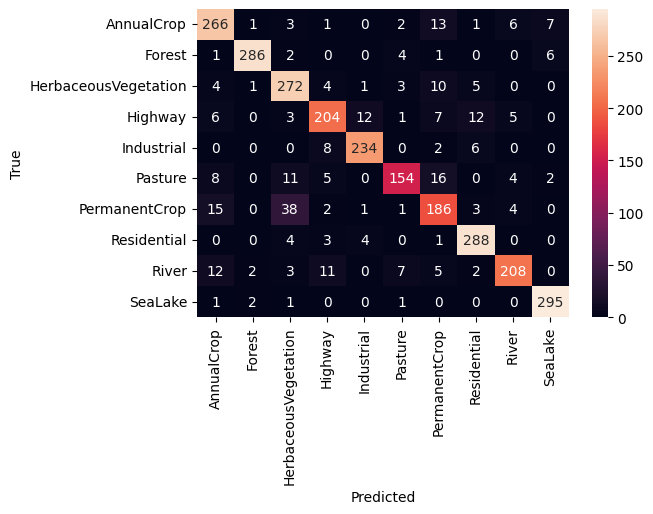

In [18]:
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Results on Datasets**

For each dataset we performed a number of trainings with different parameter combinations. Due to the limited number of computing power we had available and the limited size of GPU memory we could only experiment with networks considerably smaller than the ones used for the evaluation in the original paper. Some parameter combinations we tried, as well as the ones we got the best results with for each dataset are documented in the table below. These are also the ones used in the implementations above.

| Dataset | epochs | Lx | d_model | d_ffn | patch_size | dropout probability | Accuracy |
|---|---|---|---|---|---|---|---|
| CIFAR10 |10|4|100|400|8|0.1| 68% |
| CIFAR10 | 6 | 6 | 220 | 900 | 2 | 0.1 | 69% |
| CIFAR10 | 5 | 10 | 300 | 900 | 2 | 0.1 | 68% |
| (Tiny) ImageNet |1|1|1|2|16|0.1| 0% |
| Fashion-MNIST |10|4|100|400|8|0.1| 90% |
| Fashion-MNIST |7|6|256|512|2|0.1| 90% |
| Fashion-MNIST |9|10|300|900|2|0.1| 91% |
|EuroSAT_RGB |10|4|64|128|2|0.1| 84% |
|EuroSAT_RGB |6|6|128|256|4|0.1| 85% |
|EuroSAT_RGB |15|6|280|560|4|0.1| 89% |

## **Conclusion**

Even though the overall architecture of gMLP is fairly simple it still took us quite a while and many iterations of analyzing the architecture to fully grasp the details of how it works. Other already made implementations mentioned in the section below helped us to understand certain details of the algorithm that might have been hard to get from just the paper.<br><br>
We started out by testing our implementation only on the CIFAR10 dataset to see if it really worked. During the testing we experienced some problems with **overfitting** after around 8 epochs. To counter this issue we implemented dropout for the gMLP blocks which slightly improved our results but didnt have a huge impact. Further dropout mechanisms at other stages of the network and similar methods should be implemented as an improvement against overfitting, but we didnt have the time to do this.<br><br>
With changes to the parameters we were able to improve our results on the datasets from initially rather bad numbers to halfway decent ones in the end. There certainly is still a large amount of possible changes that could be made to further improve the network. One example would be to reconsider the embeddings of the images and use data augmentation to increase the size of the datasets. Another one would be to run it on better hardware.  The just mentioned counters against overfitting also fall into that category.<br><br>
The results we achieved for Fashion-MNIST and EuroSAT_RGB were rather satisfactory. The results on CIFAR10 were acceptable but not necessarily very good. (Tiny) ImageNet posed problems for us, as the dataset was just too big and complex to train our architecture on with the hardware we had access to.<br><br>
We didn't come around to make the architecture work with NLP datasets, but this would be interesting to test out in the future.

## **References**

Below are references we used to build this notebook. During the attempt to write our own implementation we also looked at multiple other approaches people took to implement the same architecture.

- [Paper: Pay Attention to MLPs](https://arxiv.org/pdf/2105.08050v1.pdf)

- [Github Implementation 1](https://github.com/lucidrains/g-mlp-pytorch)

- [Github Implementation 2](https://github.com/antonyvigouret/Pay-Attention-to-MLPs)

- [Notebook Implementation](https://github.com/zer0sh0t/artificial_intelligence/blob/master/multimodal_models/gmlp/gmlp.ipynb)

- [Description-Code-Side-by-Side Implementation](https://nn.labml.ai/transformers/gmlp/index.html)